In [6]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

TEST_IMAGES_PATH = "./data/test2017/test2017"  # Directory with training images

In [10]:
import torchvision.transforms as transforms
from model import EncoderCNN, DecoderRNN

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [24]:
from vocabulary_class import Vocabulary

torch.serialization.add_safe_globals([Vocabulary])

vocab = torch.load("models/vocab.pkl", weights_only=False)
encoder = EncoderCNN(256).to(device)
decoder = DecoderRNN(
    256,
    512,
    len(vocab)
).to(device)

encoder.load_state_dict(torch.load("models/encoder.pth", weights_only=True, map_location=device))
decoder.load_state_dict(torch.load("models/decoder.pth", weights_only=True, map_location=device))

d:\AIML\envs\mlenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\AIML\envs\mlenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:

def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    images = torch.stack(images, 0)

    lengths = [len(cap) for cap in captions]
    max_length = max(lengths)
    padded_captions = torch.zeros(len(captions), max_length).long()

    for i, cap in enumerate(captions):
        end = lengths[i]
        padded_captions[i, :end] = cap[:end]

    return images, padded_captions, lengths

In [ ]:
from torch.utils.data import DataLoader
from dataset import CocoDataset

test_dataset = CocoDataset(
    image_dir=TEST_IMAGES_PATH,
    captions_file=None,  # No captions for test set
    vocab=vocab,
    transform=transform
)

train_loader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    collate_fn= collate_fn
)

In [30]:
import torch


def generate_caption(image, encoder, decoder, vocab):
    encoder.eval()
    decoder.eval()
    image = image.unsqueeze(0).to(device)
    feature = encoder(image)              # [1, 256]
    feature = feature.unsqueeze(1)        # [1, 1, 256]

    # 2. Start sequence with <start> token
    start_token = vocab.word2idx["<start>"]
    end_token = vocab.word2idx["<end>"]

    sampled_ids = []
    inputs = torch.LongTensor([[start_token]]).to(image.device)

    # 3. FIRST STEP: concatenate image feature + embedding(<start>)
    embeddings = decoder.embed(inputs)     # [1,1,256]
    lstm_input = torch.cat((feature, embeddings), dim=1)  # [1,2,256]

    hiddens, states = decoder.lstm(lstm_input)

    outputs = decoder.linear(hiddens[:, -1, :])
    predicted = outputs.argmax(dim=1).item()
    sampled_ids.append(predicted)

    # 4. NEXT STEPS: only feed predicted tokens (NO concatenation!)
    inputs = torch.LongTensor([[predicted]]).to(image.device)

    for _ in range(20):
        embeddings = decoder.embed(inputs)  # [1,1,256]

        hiddens, states = decoder.lstm(embeddings, states)
        outputs = decoder.linear(hiddens[:, -1, :])
        
        predicted = outputs.argmax(dim=1).item()
        sampled_ids.append(predicted)
        
        if predicted == end_token:
            break

        inputs = torch.LongTensor([[predicted]]).to(image.device)

    words = [vocab.idx2word[id] for id in sampled_ids]
    return " ".join(words)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.5877128].


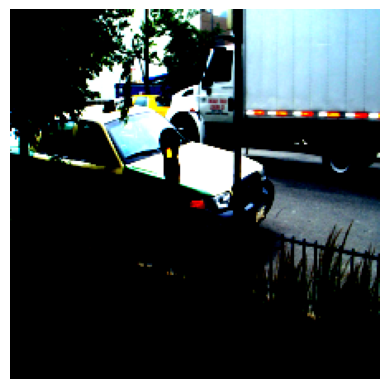

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6897851..2.6051416].


Image: 000000000001.jpg
Caption: a large jetliner parked on a runway with a <unk> <unk> . <end>



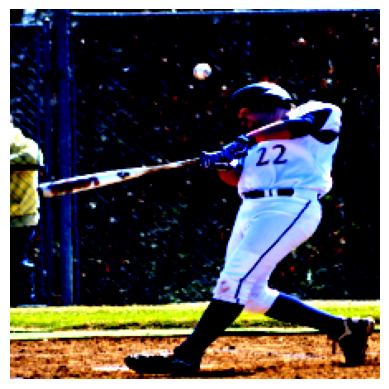

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


Image: 000000000016.jpg
Caption: a man riding a motorcycle with a <unk> <unk> <unk> . <end>



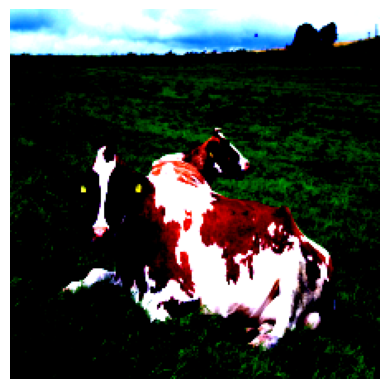

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.5877128].


Image: 000000000019.jpg
Caption: a man riding a motorcycle on a street . <end>



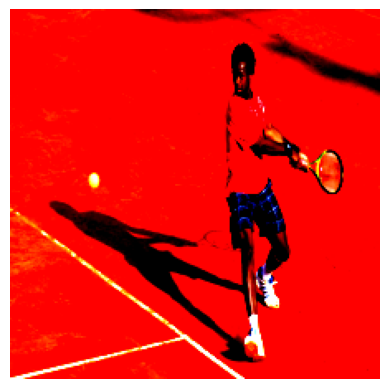

Image: 000000000057.jpg
Caption: a man riding a motorcycle on a motorcycle . <end>



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.5877128].


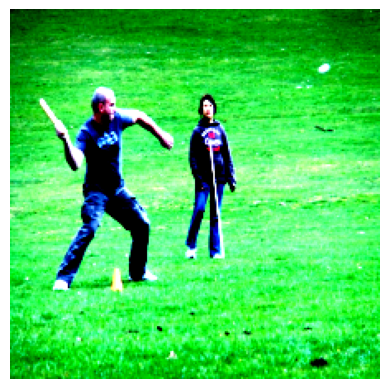

Image: 000000000063.jpg
Caption: a man riding a motorcycle on a motorcycle . <end>



In [31]:
#  test the model on a few images
import os
import matplotlib.pyplot as plt
from PIL import Image

for file_name in os.listdir(TEST_IMAGES_PATH)[:5]:
    # Load image
    img_path = f"{TEST_IMAGES_PATH}/{file_name}"
    image = Image.open(img_path).convert("RGB")

    image = transform(image)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()
    
    caption = generate_caption(image, encoder, decoder, vocab)
    print(f"Image: {file_name}\nCaption: {caption}\n")
